# Independent Component Analysis (ICA) for removing biological artefacts

In [1]:
# Authors: Denis Engemann <denis.engemann@gmail.com>
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#          Jona Sassenhagen <jona.sassenhagen@gmail.com>
#
#
# License: BSD (3-clause)

import numpy as np

import mne
from mne.io import Raw
from mne.datasets import sample
from mne.utils import set_log_level

In [2]:
# ICA related functionality
from mne.preprocessing import ICA, read_ica
from mne.preprocessing import create_ecg_epochs, create_eog_epochs

In [5]:
set_log_level('warning')  # we don't want to see all loging outputs today

In [6]:
# getting some data ready
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = Raw(raw_fname, preload=True)
raw.filter(1, 45, n_jobs=2)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec)>

In [7]:
# as usual we re picky
picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=False,
                           stim=False, exclude='bads')
# we start by looking at magnetometer and gradiometer signals

# Before fitting models let's look at what we want to get rid off

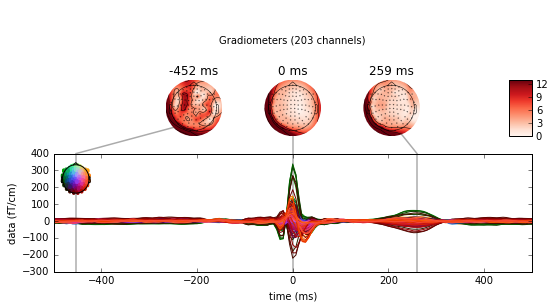

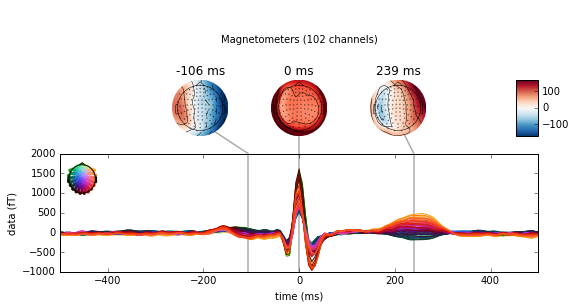

In [8]:
%matplotlib inline 
# ECG
reject = dict(mag=4e-12, grad=4000e-13)  # don't fit on crazy environmental artefacts
ecg_average = create_ecg_epochs(raw, reject=reject, picks=picks_meg).average()
ecg_average.plot_joint();
# What is the order of magnitude of the average artefact?
# Do we see different spatial patterns?

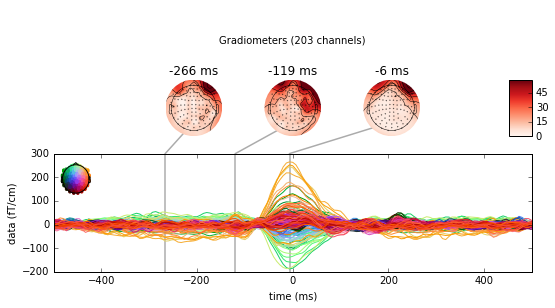

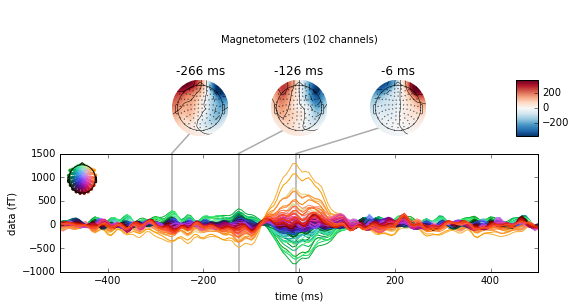

In [9]:
# EOG
reject = dict(mag=4e-12, grad=4000e-13)  # don't fit on crazy environmental artefacts
eog_average = create_eog_epochs(raw, reject=reject, picks=picks_meg).average()
eog_average.plot_joint();

# Fit ICA model using the FastICA algorithm

In [10]:
# ICA parameters
n_components = 25  # if float, select the number components by explained variance of PCA
method = 'fastica'  # for comparison with EEGLAB try "extended-infomax" here
decim = 3  # we only need enough statistics, not all time points

In [11]:
# Let's fit 
ica = ICA(n_components=n_components, method=method)
print(ica)
ica.fit(raw, picks=picks_meg, decim=decim, reject=reject)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
<ICA  |  raw data decomposition, fit (fastica): 13534 samples, 25 components, channels used: "mag"; "grad">


# Plot ICA components

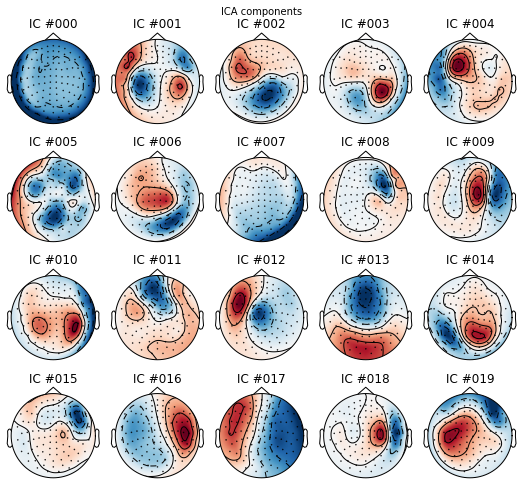

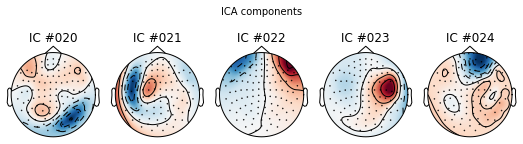

In [12]:
ica.plot_components()  # can you see some potential bad guys?

# Let's use a more efficient way to find artefacts

In [13]:
# We simplify the detection game by setting the maximum number of components to reject
n_max_eog = 1  # here we bet on finding the vertical EOG components
eog_epochs = create_eog_epochs(raw, reject=reject)  # get single EOG trials
eog_inds, scores = ica.find_bads_eog(eog_epochs)  # find indices via correation

In [16]:
ica.plot_scores(scores, exclude=eog_inds)  # look at correlation with components
ica.plot_sources(eog_average, exclude=eog_inds);  # look at source time course
# and pay closer attention to the labels, a customized read-out of the ica.labels_
print(ica.labels_)  # only there if .fit got called.

{u'eog/0/EOG 061': [22], 'eog': [22]}


In [15]:
# plot what we would remove with this component
%matplotlib
ica.plot_overlay(eog_average, exclude=eog_inds);

Using matplotlib backend: MacOSX


Let's save our ICA

In [40]:
ica.exclude.extend(eog_inds)  # append definitions of bads
# uncomment this for reading and writing
# ica.save('my-ica.fif')
# ica = read_ica('my-ica.fif')

# Basic Excercises 
1. Now look at the EEG.
2. Which dominating artefacts do you find? Plot them.
3. Fit ICA for EEG only.
4. Inspect components. Do you find one or a few components undoubtfully related to your artefact? Use plotting for clarification
5. Identify bad components.
6. Remove them and plot the cleaned data and raw data.
7. Refit everything once more. What do you observe? Can you find the seed of evil?

# Ok but what if we don't have EOG channels?

1. make a bipolar reference from frontal EEG sensors and use as virtual EOG channel. However, Jona will tell you why this might not such a great idea.
2. Go for a semi-automated approach, using template matching.

In MNE-Python option 2 is easily achievable and it might be better, so let's have a look at it.

In [17]:
from mne.preprocessing.ica import corrmap

In [21]:
# look at the docs!
# corrmap?

The idea behind corrmap is that artefact patterns are similar across subjects and can thus be identified by correlating the different patterns resulting from each solution with a template. The procedure is therefore semi-automaric.
Corrmap hence takes at least a list of ICA solutions and a template, that can be an index or an array.
As we don't have different subjects or runs available today, here we will fit ICA models to different parts of the recording and then use a user-defined template from the first part for detecting corresponding components in the other parts. The code in the next cell addresses this point and *should not be copied*, ok?

In [43]:
# simulating a group of subjects or runs from a subject

start, stop = raw.index_as_time([raw.first_samp, raw.last_samp])
intervals = np.linspace(start, stop, 4)
icas = list()
seed = 42  # for reproducible results
for ii, start in enumerate(intervals):
    if ii + 1 < len(intervals):
        stop = intervals[ii + 1]
        print('fitting ICA from {} to {} seconds'.format(start, stop))
        this_ica = ICA(n_components=n_components, method=method, random_state=seed).fit(
            raw, start=start, stop=stop, reject=reject)
        icas.append(this_ica)

fitting ICA from 42.9559708291 to 135.525532979 seconds
fitting ICA from 135.525532979 to 228.095095129 seconds
fitting ICA from 228.095095129 to 320.664657279 seconds


In [44]:
print(icas)

[<ICA  |  raw data decomposition, fit (fastica): 13244 samples, 25 components, channels used: "mag"; "grad"; "eeg">, <ICA  |  raw data decomposition, fit (fastica): 12943 samples, 25 components, channels used: "mag"; "grad"; "eeg">, <ICA  |  raw data decomposition, fit (fastica): 6622 samples, 25 components, channels used: "mag"; "grad"; "eeg">]


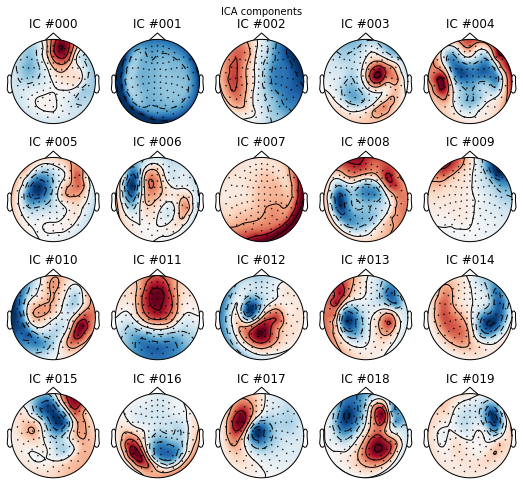

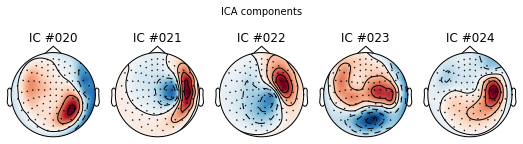

In [45]:
% matplotlib inline
icas[0].plot_components()

with random seed = 42 we see that IC number 10 from run 1 looks like an EOG component

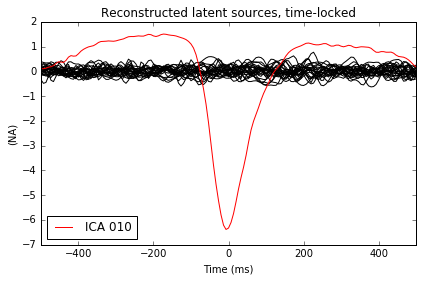

In [54]:
icas[0].plot_sources(eog_epochs.average(), exclude=[9]);

In [55]:
# So our template should be a tuple like (reference_run_index, component_index):
template = (0, 9)

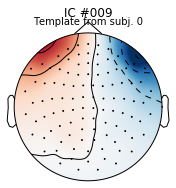

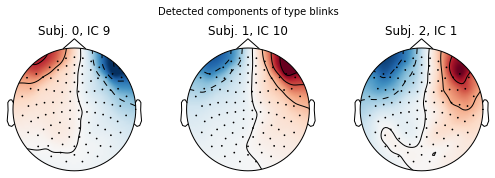

In [58]:
# now we can do the corrmap
fig_template, fig_detected = corrmap(icas, template=template, label="blinks",
                                     show=True, threshold=.8, ch_type='mag')

# Nice, we have found similar ICs from the other runs!

This is even nicer if we have 20 or 100 ICA solutions in a list.